# AM207 - Predictive Uncertainty Estimation via Dirichlet Prior Networks

## by Tianhao Wang, Zhenru Wang, Zhao Lyu

*Based on [Predictive Uncertainty Estimation via Prior Networks](https://arxiv.org/pdf/1802.10501.pdf) by Andrey Malinin and Mark Gales*.

**Notebook Overview**

In this paper review, we begin by describing the problem and reviewing the existing works in uncertainty estimation. 
We then introduce the concept of Prior Network (PN) discussed by Malinin and Gales in their NIPS 2018 paper, as well as discuss the implementation method of it. We also introduce how to use PN to estimate uncertainty using different uncertainty measuring metrics. 
After doing so, we implement the Dirichlet Prior Network (DPN) proposed in the paper and
test its performance of uncertainty estimation on MNIST and Fashion-MNIST dataset. 

## Problem statement and Context
**I'm sorry ... why we need to estimate uncertainties of DNN prediction?** 

In the last five years, Deep Neural Networks (DNNs) have enjoyed tremendous progress. 
We are already adopting DNNs in security-critical domains like autonomous driving [1]. Hence, it is extremely important for Deep neural networks (DNNs) to determine their uncertainties in predictions, since engineers need to determine the source of uncertainties first in order to improve the safety of the system. 

**So, what are the main sources of uncertainties?** 

In AM207, we learned that there are two kinds of uncertainties: epistemic uncertainty (*model uncertainty*) and aleatoric uncertainty (*data uncertainty*). However, in the paper, the authors propose a third kind of uncertainty source: *distributional uncertainty*. We introduce the three kinds of uncertainties in the following: 
- Model uncertainty, or epistemic uncertainty, is the uncertainty origins from estimating the model parameters given the training dataset, which can be minimized given enough training data. 
- Data uncertainty, or aleatoric uncertainty, is inherited from the complexity of training data, e.g. overlapped data labels, and cannot be avoided easily. 
- Distributional uncertainty, which is introduced by the *distributional mismatch* between the training and test data. This kind of uncertainty also need to be explicitly indicated and avoided in the practical situation. For example, when the DNN was asked to make predictions on some out-of-distribution (OOD) samples, the result should not be confident and therefore requires additional training data. 

|Data Uncertainty|Distributional Uncertainty|
|:-------------------------:|:-------------------------:|
|![data](images/indomain.png)|        ![dist](images/ood.png)|


Recently there have been significant developments in the estimation of model and data uncertainties. However, most of those approaches tend to conflate distributional uncertainty with the other two uncertainties in estimating uncertainties of deep learning models. Therefore, **this paper proposes Prior Network to explicitly distinguish distributional uncertainties from others.**

## Existing work
**You said existing approaches do not identify distributional uncetainty, what are they?**
$\newcommand{\class}{\omega _c}$

Let $\textbf{x}$ denote the input features and $y$ be the labels. For a Bayesian model, the predictive uncertainty $p( y = \class | \textbf{x} , \mathcal{D} )$ 
on the data set $ \mathcal{D} = \{ x_j, y_j \}^N_{j = 1} $ describes both model and data uncertainty. Let $\theta$ denotes model parameters, then the predictive uncertainty can be rewritten using Bayesian rule as:
$$ p( y = \omega _c | \textbf{x}^* , \mathcal{D} ) = \int \underbrace{p(y = \omega_c | \textbf{x}^*, \theta)}_{data} \underbrace{p (\theta | \mathcal{D})}_{model} d\theta$$
We can see in this case, the model uncertainty, $ p (\theta | \mathcal{D}) $, and the integral in the equation above are both *intractable* and can only be reasonably approximated. 
As a result, several methods have been introduced in order to perform uncertainty estimation:

- The first class of approaches originated from Bayesian Neural Network (BNN). In general they are computationally heavy and hard to implement. An example would be *Monte-Carlo Dropout* [7]. This uses Monte-Carlo sampling methods to approximate the integral with random forward passes and its prediction is a distribution rather than a deterministic class. For example, given an image of cat for the Monte-Carlo Dropout classifier and run it several times, the result would not be the same for each run. Instead it would perhaps results in cat 70% of times and results in dog 30% of times. 
This approach has been proved to be helpful for several computer vision applications, but its performance is not stable due to the complicated nature of prior distribution over parameters. Also, it does not explicitly predict distributional uncertainty and mixed it with data uncertainty.  

- The second class is non-bayesian approach. An example would be *Deep Ensembles* [6]. It first sets up a training criterion, then uses adversarial training to smooth predictive distribution and finally train an ensemble. This approach results a similar uncertainty estimation compared to Monte-Carlo Dropout, and it is easier to implement. However, this model also conflate the distributional uncertainty with data uncertainty. 

- Another class of approaches is through training DNN explicitly to yield high entropy posterior distributions for OOD samples. Lee and his group had developed the uncertainty estimation method for classification DNN [8].  Malinin (the author of this paper) also developed the method for regression DNN [9]. These methods have better uncertainty estimation compared to the previous two classes of approaches, and are more computationally efficient at test time. However, due to the complexity of the loss function, it is poorly suited for optimization and computationally inefficient in training for datasets with large number of classes. Besides, high entropy of a prediction could indicate the sample is from either an in-domain overlapped region, or a far, OOD region, hence this approach still has same issue as the previous two classes. 


**Significance of the paper**

As a result, the paper has developed a new scheme called Prior Network (PN), which can model distributional uncertainty distinctly. It aims to achieve sharp posterior distributions for in-domain samples and flat posterior distributions for OOD samples. The significant contribution of Prior Networks is that this new approach can distinguish data uncertainty and distributional uncertainty through a range of uncertainty measures, especially differential entropy (D.Ent.). 


## Prior Network

Okey, so much about related works, let's introduce the main character: Prior Networks now!

**Distributions on a Simplex**

As suggested in the existing work, previous methods construct an *implicit conditional distribution over distributions* on a simplex by Bayesian approaches as shown below.
$$
P(\omega_c | \textit{x}^*, \mathcal{D}) = \int P(\omega_c|\textit{x}^*, \theta)p(\theta|\mathcal{D})d\theta
$$
The data uncertainty in predictions therefore is addressed by $P(\omega_c|\textit{x}^*, \theta)$, and the model uncertainty is represented by $p(\theta|\mathcal{D})$ given the model parameters $\theta$.

However, this is usually not easy and less preferable as it fails to distinguish data, distributional and model uncertainties. In other words, if we ever input a test data completely different from our training set, the Bayesian approach can hardly tell whether a resulting uncertainty in prediction comes from the data uncertainty or the distributional uncertainty. Therefore, we want a new approach to tell us what kinds of uncertainty it is in our prediction. 
Prior Network, however, introduced an explicit distribution over posterior predictive distributions over a simplex. 
A PN will have a *sharp distribution* in the simplex if it's confident about its prediction. A great data uncertainty, either due to noise or class overlap, will still result in the PN which has the sharp distribution at the center of the simplex (known-unknown). 
However, for a mismatch between test and training dataset, since the model didn't seen similar data before, a PN will warn OOD by generating a *flat distribution* over the simplex, meaning that the prediction is mostly uncertain (unknown-unknown). The following are the desired behavior of a PN: 





|Confident Prediction|High Data Uncertainty| High Distributional Uncertainty|
|:-------------------------:|:-------------------------:| :------------------------------:|
|![conf](images/clear.png)|        ![dataun](images/dataun.png)| ![distun](images/distun.png)|

**Theoretical Foundation of Prior Network: Parameterizing Distributional uncertainty**

An explicit parameterization is applied to help distinguishing the data and distributional uncertainty in prior network. Specifically, a parameter $\mu = P(y = \omega)$ is introduced to define a point estimate categorical distribution $p(\mu | \textit{x}^*, \theta)$ for the expected distribution.
$$
P(\omega_c | \textit{x}^*, \mathcal{D}) = \int\int p(\omega_c|\mu)p(\mu|\textit{x}^*,\theta)p(\theta|\mathcal{D})d\mu d\theta
$$
Here, we still have $p(\theta|\mathcal{D})$ for the model uncertainty given the model parameters $\theta$. However, $p(\mu|\textit{x}^*,\theta)$ now is the *distribution of predictive distributions* and $\mu$ can be viewed as "vector of probabilities" $\mu=[p(y=\omega_1), ..., p(y=\omega_K]$, where the distribution of $\mu$ explicitly describes the distributional uncertainty; $p(\omega_c|\mu)$ is for the data uncertainty. This implies a *hierarchical model* for uncertainty as the distributional uncertainty is extracted from the data uncertainty. 

General idea of the hierarchy is not complex: the model uncertainty influences distributional uncertainty estimations, and both further influence estimations of data uncertainty. 
This claim can be illustrated by the formula. 
$p(\mu|\textit{x}^*,\theta)$ is a conditional probability, as given the dataset $\mathcal{D}$. The greater the model uncertainty is, the more variance the distribution uncertainty has. Furthermore, the data uncertainty $p(\omega_c|\mu)$ depends on both the model and distribution uncertainties. That is, an increase in uncertainty of $\mu$ leads to an increase in data uncertainty estimations. 

If we consider the order of the double integral above:
$$
P(\omega_c | \textit{x}^*, \mathcal{D}) = \int\big[\int p(\omega_c|\mu)p(\mu|\textit{x}^*,\theta)d\mu\big]p(\theta|\mathcal{D}) d\theta \\
= \int p(\omega_c|\textit{x}^*, \theta)p(\theta|\mathcal{D})d\theta~~~~\text{(Bayesian Approaches)}\\
P(\omega_c | \textit{x}^*, \mathcal{D}) = \int p(\omega_c|\mu)\big[\int p(\mu|\textit{x}^*,\theta)p(\theta|\mathcal{D}) d\theta\big]d\mu \\
= \int p(\omega_c|\mu)p(\mu|\textit{x}^*, \mathcal{D})d\mu~~~~\text{(Prior Network)}
$$
Integrating the data and distributional uncertainty first again turns out to be what we obtain for estimates of uncertainty using Bayesian approaches, and it's clear that we have no information of the sharpness of the distribution of posterior distribution since we lose $\mu$. 
On the other hand, integrating the latter two gives estimates of data uncertainty and distribution uncertainty given the model uncertainty. This explicitly yields the distribution over the simplex, which **is exactly what Prior Network tries to model**.
However, this conditional probability $p(\mu|\textit{x}^*, \mathcal{D})$ depends on both training data $\mathcal{D}$ and the test data $\textit{x}^*$, and its marginalization is generally difficult to track. Hence, the paper assumes that
$$
p(\mu|\textit{x}^*, \mathcal{D}) \approx 
p(\mu|\textit{x}^*, \hat\theta)
$$
given appropriate regularization and training data size for the training of Prior Networks.



## Dirichlet Prior Networks
$\newcommand{\dir}{Dir}$
$\newcommand{\alphavec}{\vec{\alpha}}$
$\newcommand{\muvec}{\vec{\mu}}$

### What is, and why Dirichlet?

Okey, we know what Prior Network is trying to do now, but how exactly can we implement it? Which is, how exactly can we model $p(\mu|\textit{x}^*,\theta)$, the distribution of distributions?

For classification tasks, we need to parameterize a distribution over a simplex. However, what type of distribution can be a prior distribution over distributions? 
The paper chose **Dirichlet distribution**, mainly because of its tractable analytic properties. 

The Dirichlet distribution (after Peter G. L. Dirichlet), often denoted $\dir(\alphavec)$, is the *conjugate prior* of the categorical distribution. It is parameterized by *concentration* parameter $\alphavec=(\alpha_1, \dots, \alpha_K)$, where $K$ is the total number of categories. 
Denote $\alpha_0$ be the sum of all $\alpha_i$s, the Dirichlet distribution defined as:
$$
\dir(\muvec|\alphavec) = \frac{\Gamma(\alpha_0)}{\prod_{i=1}^K\Gamma(\alpha_i)} \prod_{i=1}^K \mu_i^{\alpha_i-1}, \alpha_i>0
$$
where $\Gamma$ is the Gamma function. For each $\mu_i$, $E[\mu_i] = \frac{\alpha_i}{\alpha_0}$, i.e. the expected probability for class $i$ is the ratio between $\alpha_i$ and $\alpha_0$.  

The sum of all $\alpha_i$s, $\alpha_0$, is called the *precision* of the Dirichlet distribution, which characterizes the sharpness of categorical distributions. As an illustration, when $\alphavec = (0.2, 0.2, 0.2)$, each class should have same expected probability. However, the distribution of distributions on the simplex looks like:

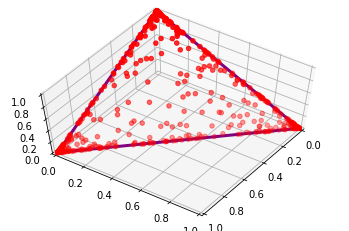

In [0]:
from utility import plot_dir

alpha1 = [0.2, 0.2, 0.2]
plot_dir(alpha1, 500)

Hmmm, looks very dispersing. Okey, now we keep the proportion of each class the same, but increase $\alpha_0$, e.g. let $\alphavec = (1, 1, 1)$, we have:

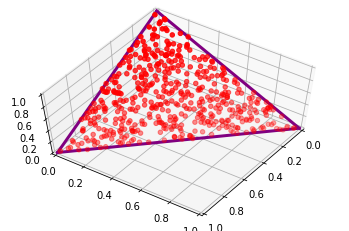

In [0]:
alpha2 = [1.0, 1.0, 1.0]
plot_dir(alpha2, 500)

It's a flat, uniform distribution over simplex! That's exactly what we want for OOD data!

If we further incrase the precision $\alpha_0$:

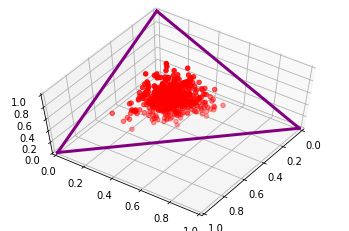

In [0]:
alpha3 = [10.0, 10.0, 10.0]
plot_dir(alpha3, 500)

The distribution of distributions are more concentrated on the uniform distribution now! That's what we want for overlapped data! 
We found that higher values of $\ao$ lead to sharper, more confident distributions! Therefore, the desired behavior of PN can be achieved by outputting high $\alpha_0$ for overlapped data, and low $\alpha_0$ for OOD data!

### Comparison with DNN
$\newcommand{\ao}{\alpha_0}$
$\newcommand{\xstar}{\textit{x}^*}$
$\newcommand{\classi}{w_i}$
As we can see, the ability of explicitly control the magnitude of $\ao$ is the key of achiving the desired behaviors of a Prior Network described above. In the paper, a DPN will generate the concentration parameters $\alphavec$ of the Dirichlet distribution. 
$$
\alphavec_x = PN(\xstar, \hat\theta)
$$
and the predictive distribution is then given by the expected categorical distribution under the conditional Dirichlet prior:
$$
p(y=\classi|\xstar, \hat\theta) = E_{p(\muvec|\xstar, \hat\theta)}[p(\classi|\muvec)] = \hat\mu_i = \frac{\hat\alpha_i}{\hat\alpha_0}
$$
Or we can see more clear from a hierarchical structure:
$$
\begin{aligned}
\alphavec_x &= PN(x^*, \hat\theta) \\
\muvec_x &\sim Dir(\alphavec_x) \\
y_x &= argmax (E[\muvec_x])
\end{aligned}
$$
Comparison with DNN and BNN:
1. DNN 
$$
\begin{aligned}
\muvec_x &= DNN(x^*, \hat\theta) \\
y_x &= argmax (\muvec_x)
\end{aligned}
$$

2. Baysian
$$
\begin{aligned}
\hat\theta &\sim p(\theta | (X, Y)) \\
\muvec_x &= BNN(x^*, E[\hat\theta]) \\
y_x &= argmax (\muvec_x)
\end{aligned}
$$

If an exponential output function is used for the DPN, i.e. $\alpha_i = e^{z_i(\xstar)}$ where $z_i(\xstar)$ is the pre-softmax (logit) output corresponding to the class, then the expected posterior probability of class label $w_i$ is given as:
$$
p(w_i|x^*, \hat\theta) = \frac{\hat\alpha_i}{\hat\alpha_0} = \frac{e^{z_i(x^*)}}{\sum_{i=1}^K e^{z_i(x^*)}}
$$
Wait! Isn't it looks familiar from CS281? 

Therefore, the paper claims that *a standard DNN with the softmax activation function can hence be represented as a DPN.*

Okey, I'm confused again. **What is the special property of DPN, compared with DNN?**

Well, the expectation of the Dirichlet is **insensitive** to any arbitrary scaling of $\alphavec$, i.e. no matter what $\ao$ is, the prediction of DNN will be the same. 
Hence, the precision of the Dirichlet, $\ao$, which is the key of controlling the sharpness of the distributions, degrades under the standard cross-entropy loss. DPN tries to address this problem. The paper instead introduced a new loss function that explicitly minimizes the KL divergence between the output Dirichlet and a target Dirichlet to produce a predefined target precision value for the output Dirichlet distributions.

### DPN Training

**Okey, now we know how DPN works and its desired behavior. But how can we train it?**

The natural training criterion (loss function) for DPN is the KL divergence between the current and a target Dirichlet distribution $\dir(\muvec|\alphavec)$:
$$
\mathcal{L}(\theta) = E_{p_{in}(x)}[KL[\dir(\muvec|\hat\alpha)||p(\muvec|x, \theta)]]
 + E_{p_{out}(x)}[KL[\dir(\muvec|\tilde\alpha)||p(\muvec|x, \theta)]]
$$
where the target distribution for OOD data is simply a flat Dirichlet distribution with all $\tilde\alpha_i=1$. 
The target concentration parameters $\hat\alpha$ for in-domain data, however, depends on the class $c$ the sample belongs to:
$$
\hat\alpha_k^{(c)} = 
\begin{cases}
1+\lambda & \mbox{if $c=k$}\\
1 & \mbox{if $c\ne k$}
\end{cases}
$$
The value $\lambda$ is a hyperparameter for DPN training, and usually should take on a large value, for example 100, so that we can ensure that the concentration is high only in the corner corresponding to the target class, and low elsewhere.
However, you might wonder **why the rest of the concentration parameters are not set as 0** (i.e. why don't we use a one-hot encoding as the target $\alphavec$)? Let's illustrate this point by some simple experiments: in PyTorch, the KL-divergence between two Dirichlet distributions where one of them has concentration parameter to be (1, 0, 0):

In [0]:
import torch.distributions as dist
from torch.distributions.dirichlet import Dirichlet

dirichlet1 = Dirichlet(torch.tensor([1.1, 1.1, 1.1]))
dirichlet2 = Dirichlet(torch.tensor([1.0, 0.0, 0.0]))

print(dist.kl.kl_divergence(dirichlet1, dirichlet2))

tensor(inf)


Ahhhhhhh that's not very good for training. 
As the paper suggested, learning sparse one-hot target is challenging under the defined KL loss, as the error surface becomes poorly suited for gradient-based optimization. Hence, the rest of concentration parameters are set to be 1, which redistributes a small amount of probability density to the other corners of the Dirichlet and provides a small degree smoothing. 

<!--
Although it has been pointed out in [2], there is a significant issue with this criterion, this is out-of-scope of this paper and we implement . -->


Okey, another question about the loss function is, **what exactly is the OOD distribution $p_{out}(x)$?** That is, how can we get the OOD data?

Unfortunately, the true out-of-domain distribution, $p_{out}(x)$, is unknown. The paper proposes two solutions: 
- synthetically generate points on the boundary of the in-domain region using a generative model, e.g. GAN.
- use a different, real dataset as a set of samples from the out-of-domain distribution, e.g. Fashion-MNIST for MNIST. 

## Uncertainty Measures
**Now we know how to build DPN. What can we do after we obtain the DPN?**

We have explored different means for modeling uncertainty, but how can we quantify uncertainties to further tell which one is better among DNN, DPN or Bayesian MC? 
In the paper, a few classes of measures from the expected predictive categorical distribution are discussed based on how we deal with marginalization in 
$$
p(w_c|x^*, \mathcal{D}) = \int\int p(\omega_c|\mu)p(\mu|\textit{x}^*,\theta)p(\theta|\mathcal{D})d\mu d\theta
$$
As categorized as below, we discuss these measures algebratically and experimentally here. We chose different values of categorical distribution / dirichlet distribution and carry out trials on uncertainty measures.
- Full marginalization
 - Max Probability
 - Entropy 
- Marginalizing out $\mu$
 - Mutual Information (MI) for model uncertainty
- Marginalizing out $\theta$
 - Mutual Information for distributional uncertainty
 - Differential Entropy

### 1. Measure uncertainty from the expected predictive categorical distribution $p(w_c|x^*, \mathcal{D})$ given full marginalization

One way to view the uncertainty measure is to find the maximal probability of the predicted class. This is called *max probability* $\mathcal{P}$, defined as below

$$
\mathcal{P} = \max_c P(\omega_c|\textit{x}^*, \mathcal{D})
$$

While the *max probability* only captures one case, another measure called *entropy* helps analyze the whole distribution as it includes all information in the distribution. It is denoted as $\mathcal{H}[P(y|\textit{x}^*, \mathcal{D})]$ and defined as:
$$
\mathcal{H}[P(y|\textit{x}^*, \mathcal{D})] = -\sum_{c=1}^K P(\omega_c|\textit{x}^*,\mathcal{D})\ln(P(\omega_c|\textit{x}^*,\mathcal{D}))
$$

As both $\mathcal{P}$ and $\mathcal{H}[P(y|\textit{x}^*, \mathcal{D})]$ analyze the whole predictive distribution, they can be regarded as the *total uncertainty* measures, which highlight overall performances in our predictions, but do not suggest which sources of uncertainties in the predictions. 
Entropy is typically higher when uncertainty is high, while max probability is typically lower when uncertainty is high. 


In [3]:
from utility import numpy_to_tensor
import torch


def max_prob(alphas):
  alpha0 = torch.sum(alphas, dim=1, keepdim=True)
  probs = alphas / alpha0
  conf = torch.max(probs, dim=1)
  return conf

def entropy(alphas):
  alpha0 = torch.sum(alphas, dim=1, keepdim=True)
  probs = alphas / alpha0
  ret = -torch.sum(probs*torch.log(probs), dim=1)
  return ret

alpha1_tensor = numpy_to_tensor([1/3, 1/3, 1/3])
alpha2_tensor = numpy_to_tensor([0.98, 0.01, 0.01])
print('Given categorical distribution = {}\nThe max probability: {}\nEntropy: {}\n'.format(alpha1_tensor.numpy(), 
                                                                                           max_prob(alpha1_tensor)[0].numpy(), 
                                                                                           entropy(alpha1_tensor).numpy()))
print('Given categorical distribution = {}\nThe max probability: {}\nEntropy: {}\n'.format(alpha2_tensor.numpy(), 
                                                                        max_prob(alpha2_tensor)[0].numpy(), 
                                                                        entropy(alpha2_tensor).numpy()))

Given categorical distribution = [[0.33333334 0.33333334 0.33333334]]
The max probability: [0.33333334]
Entropy: [1.0986123]

Given categorical distribution = [[0.98 0.01 0.01]]
The max probability: [0.98]
Entropy: [0.11190203]



### 2. Measure uncertainty from the expected predictive categorical distribution $p(w_c|x^*, \mathcal{D})$ given marginalization of $\mu$

Integrating the first two probability over $\mu$, we obtain 
$$
P(\omega_c | \textit{x}^*, \mathcal{D}) = \int\big[\int p(\omega_c|\mu)p(\mu|\textit{x}^*,\theta)d\mu\big]p(\theta|\mathcal{D}) d\theta \\
= \int p(\omega_c|\textit{x}^*, \theta)p(\theta|\mathcal{D})d\theta
$$
This tells us that the total uncertainty in prediction comes from the model uncertainty $p(\theta|\mathcal{D})$ and data uncertainty $p(y|\textit{x}^*, \theta)$. Based on this relation, *mutual information (MI)* $\mathcal{I}[y,\theta |\textit{x}^*, \mathcal{D}]$ between $y$ and model paramter $\theta$ defined as below helps measuring the model uncertainty in prediction. 
$$
\underbrace{\mathcal{I}[y,\theta |\textit{x}^*, \mathcal{D}]}_{\text{Model uncertainty}} = \underbrace{\mathcal{H}[\mathbb{E}_{P(\theta|\mathcal{D})}[P(y|\textit{x}^*,\theta)]]}_{\text{Total uncertainty}}-\underbrace{\mathbb{E}_{P(\theta|\mathcal{D})}[\mathcal{H}[P(y|\textit{x}^*,\theta)]]}_{\text{Expected data uncertainty}}
$$

However, as we mainly interested in measuring distributional uncertainty due to the mismatch between training and test dataset, we need to obtain MI between $y$ and $\mu$ instead.

### 3. Measure uncertainty from the expected predictive categorical distribution $p(\omega_c|x^*, \mathcal{D})$ given marginalization of $\theta$

Similarly, *mutual information (MI)* $\mathcal{I}[y,\mu |\textit{x}^*, \mathcal{D}]$ between $y$ and $\mu$ defined as below helps measure the distributional uncertainty in prediction, because now the spread is explicitly resulted from the distribution uncertainty. 
$$
\underbrace{\mathcal{I}[y,\mu |\textit{x}^*, \mathcal{D}]}_{\text{Distributional uncertainty}} = \underbrace{\mathcal{H}[\mathbb{E}_{P(\mu|\textit{x}^*, \mathcal{D})}[P(y|\mu)]]}_{\text{Total uncertainty}}-\underbrace{\mathbb{E}_{P(\mu|\textit{x}^*, \mathcal{D})}[\mathcal{H}[P(y|\mu)]]}_{\text{Expected data uncertainty}}
$$

Similar to entropy, MI is also larger when there are large uncertainties, and low when there are little uncertainties. 

In [0]:
def mutual_information(alphas):
  def entropy_exp(probs):
    log_probs = torch.log(probs)
    log_probs = torch.where(torch.isfinite(log_probs), log_probs, torch.zeros_like(log_probs))
    entropy = -torch.sum(probs*log_probs, dim=1, keepdim=False)
    return entropy
  alpha0 = torch.sum(alphas, dim=1, keepdim=True)
  probs = alphas / alpha0
  expected_entropy = -torch.sum((alphas/alpha0)*(torch.digamma(alphas+1)-torch.digamma(alpha0+1)), dim=1)
  total_uncertainty = entropy_exp(probs)
  mutual_info = total_uncertainty - expected_entropy
  return mutual_info

alpha1_tensor = numpy_to_tensor([1/3, 1/3, 1/3])
alpha2_tensor = numpy_to_tensor([0.98, 0.01, 0.01])
print('Given categorical distribution = {}\nMutual Information: {}\n'.format(alpha1_tensor.numpy(), 
                                                                                           mutual_information(alpha1_tensor).numpy()))
print('Given categorical distribution = {}\nMutual Information: {}\n'.format(alpha2_tensor.numpy(), 
                                                                                           mutual_information(alpha2_tensor).numpy()))

Given categorical distribution = [[0.33333334 0.33333334 0.33333334]]
Mutual Information: [0.54379463]

Given categorical distribution = [[0.98 0.01 0.01]]
Mutual Information: [0.0795083]



### Differential Entropy

Another way to measure the distributional uncertainty by using the *differential entropy* $\mathcal{H}[p(\mu|\textit{x}^*,\mathcal{D})]$ as below
$$
\mathcal{H}[p(\mu|\textit{x}^*,\mathcal{D})] = -\int P(\mu|\textit{x}^*,\mathcal{D})\ln(P(\mu|\textit{x}^*,\mathcal{D}))d\mu
$$ 
which is designed exactly for DPN since it requires the distribution of predictive distributions $p(\mu|x^*, \mathcal{D})$. 
Below are dirichlet distributions over the simplex for $\alpha_1 = [100, 1, 10]$, $\alpha_2 = [1, 1, 1]$, and $\alpha_3 = [100, 100, 100]$. 
Categorical distributions in Dirichlet distribution with concentration $\alpha_1$ concentrated at one corner, which corresponds to the posterior distribution of in-domain, non-overlapped data. 
By contrast, $\alpha_2$ gives equiprobable categorical distribution. This results in a flat distribution over the simplex, and it supposed to correspond to OOD data. 
$\alpha_3$ gives a sharp distribution over simplex concentrated in the center, which supposed to be the posterior distribution of overlapped data. 

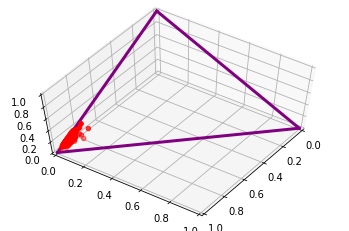

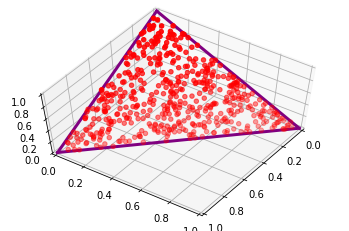

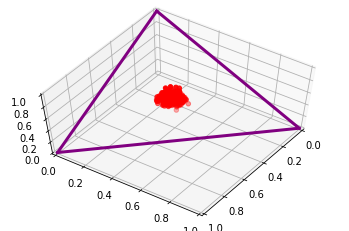

In [0]:
plot_dir([100.0, 1.0, 10.0], 500)
plot_dir([1.0, 1.0, 1.0], 500)
plot_dir([100.0, 100.0, 100.0], 500)

As we can see from the calculation in the following, the differential entropy for $\alpha_2$ are much greater than that for both $\alpha_1$ and $\alpha_3$, even though $\alpha_3$ is also a equiprobable distribution. 
Therefore, it is suggested that differential entropy as much more suitable as the score for OOD detections. 

In [0]:
# This code is modified from github.com/KaosEngineer/PriorNetworks

def differential_entropy(alphas):
  alpha0 = torch.sum(alphas, dim=1, keepdim=True)
  return torch.sum(
            torch.lgamma(alphas)-(alphas-1)*(torch.digamma(alphas)-torch.digamma(alpha0)),
            dim=1) - torch.lgamma(alpha0)

alpha1_tensor = numpy_to_tensor([100.0, 1.0, 10.0])
alpha2_tensor = numpy_to_tensor([1.0, 1.0, 1.0])
alpha3_tensor = numpy_to_tensor([100.0, 100.0, 100.0])
print('Given alpha = {}\nDifferential Entropy: {}\n'.format(alpha1_tensor.numpy(), 
                                                                             differential_entropy(alpha1_tensor).numpy()))
print('Given alpha = {}\nDifferential Entropy: {}\n'.format(alpha2_tensor.numpy(), 
                                                                             differential_entropy(alpha2_tensor).numpy()))
print('Given alpha = {}\nDifferential Entropy: {}\n'.format(alpha3_tensor.numpy(), 
                                                                             differential_entropy(alpha3_tensor).numpy()))

Given alpha = [[100.   1.  10.]]
Differential Entropy: [[-5.9265137]]

Given alpha = [[1. 1. 1.]]
Differential Entropy: [[-0.6931472]]

Given alpha = [[100. 100. 100.]]
Differential Entropy: [[-4.519287]]



## Experiment

Okey! Finally, we figured out what is Prior Network, how to implement it, and what can it be used after training. Now let's do some experiments! We show implementation of DPN first. **The implementation details of other  helper functions for the experiments are in "dpn.py" file.**

In [0]:
class PriorNet(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 3)        

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

    def predict_alpha(self, x):
      src = torch.Tensor([x]).to(device)
      output = torch.exp(self.forward(src))
      return output

    def predict_dir(self, x):
      alpha = self.predict_alpha(x)
      dirichlet = Dirichlet(alpha)
      return dirichlet

    def fit(self, epoch_num, optimizer, train_X, train_Y):
      self.train()

      n_train = len(train_X)

      # Shuffle the input
      index = np.arange(n_train)
      np.random.shuffle(index)
      train_x = train_X[index]
      train_y = train_Y[index]

      for epoch in range(epoch_num):
        for i in range(n_train):
          optimizer.zero_grad()
          src = torch.Tensor(train_x[i:i+1]).to(device)
          target = torch.Tensor(train_y[i:i+1]).to(device)
          # Predicted alpha
          output = torch.exp(self.forward(src))
          dirichlet1 = Dirichlet(output)
          dirichlet2 = Dirichlet(target)
          loss = dist.kl.kl_divergence(dirichlet1, dirichlet2)
          loss.backward()
          optimizer.step()
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, loss.item()))

### Synthetic Experiment

Similar to the synthetic experiment from the paper, we first construct a simple dataset with three classes where the data points are sampled from three different isotropic Gaussian distributions. 
We select isotropic covariances, $ I\sigma^2 $ with $\sigma=0.1$ for the *non-overlap case* (as shown in top-left figure), and with $\sigma=3$ for the *overlap case* (as shown in bottom-left figure). 
The two figures in the left shows the "true entropy" map directly calculated by the probability density of each of the three distributions (green means high entropy here). As we can see, when data classes are non-overlapped, the entropy only high on the boundary. However, when data classes are overlapped, the entropy are also high in the overlapped area, which is still counted as "in-domain". We train a small DPN with 1 hidden layers of 50 nodes each for the synthetic dataset. **Details of implementation can be found in "syn.py" file.**

Max probability and entropy are the most frequently used uncertainty measures used by the existing OOD detection models [3]. 
However, this synthetic experiment in the paper was designed to illustrate the **limitation** of using uncertainty measures derived from $P(\omega_c|\textit{x}^*, \mathcal{D})$. 
As previously suggests, since the predicted distribution is obtained by marginalizing $\mu$, these measures cannot capture the sharpness of the distribution of predictive distributions (output Dirichlet for a DPN). 
Hence, they cannot distinguish between overlapped examples and OOD examples.
As we can see from **middle-down** figure, both OOD area and overlapped area have high entropy. This indicates that the existing non-DPN approaches cannot differentiate between data and distributional uncertainties, as claimed before.  

A DPN framework address this limitation by using the *differential entropy* uncertainty measure, which produces higher scores for flat Dirichlet (OOD) and lower scores for sharper Dirichlet distributions (in-domain), even if the Dirichlet distribution is centered in the simplex (overlapped area). 
Top-right and bottom-right figures demonstrate that differential entropy can distinguish between overlapped and OOD examples. As we can see, when data are overlapped, the differential entropy is low over the whole data area and high over the non-data area, which makes the in-distribution region to be clearly distinguished from the out-of-distribution region.


|True Entropy|non-overlap entropy| non-overlap differential entropy|
|:-------------------------:|:-------------------------:| :------------------------------:|
|![overlaptrue](images/nonoverlap-true.png)|        ![overlap-entropy](images/nonoverlap-entropy.png)| ![overlap-DE](images/nonoverlap-DE.png)|

|True Entropy|overlap entropy| overlap differential entropy|
|:-------------------------:|:-------------------------:| :------------------------------:|
|![overlaptrue](images/overlap-true.png)|        ![overlap-entropy](images/overlap-entropy.png)| ![overlap-DE](images/overlap-DE.png)|

### Misclassification Experiment

The paper also presents an in-domain *misclassification detection* experiment and an *out-of-distribution (OOD) input detection* experiment to evaluate the performance of DPN to estimate uncertainty. We reproduce misclassification detection first.  

The misclassification detection experiment involves detecting whether a given prediction is incorrect given an uncertainty measure mentioned previously, e.g. max probability or entropy. 
As what the paper did, we defines the misclassified examples as the positive class and correctly classified examples as the negative class.
We run the misclassification detection experiment on MNIST dataset [4], where we use Fashion-MNIST dataset [5] serve as the OOD data for MNIST. Fashion-MNIST is designed to serve as a direct *drop-in replacement* for the original MNIST dataset for benchmarking machine learning algorithms, as it shares the same image size and structure of training and testing splits. Since MNIST contains images of hand-written digits and Fashion-MNIST contains images of clothes, Fashion-MNIST can surely be considered as the OOD data for MNIST. We train a convolutional neural network (CNN) as the DPN with two CONV layers and two fully-connected layers. **Details of implementation can be found in "miscood.py" file.**

How do we evaluate the performance of misclassification detection? We have the label (1 for misclassification, 0 for correct), and different kinds of scores (uncertainty measures). 
Should we set a threshold first for calculating the accuracy of binary prediction? And which threshold should we use? Facing this problem, the paper assessed the performance by **Area Under Receiver Operating Characteristic (AU-ROC)** and **Area Under Precision-Recall (AU-PR)**. 
Both AUROC and AUPR are threshold-independent performance evaluation metrics. 
The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at *various threshold* settings. The true-positive rate is exactly the "detection probability". Hence, the AUROC can be interpreted as the probability that a positive example has a greater detector score/value than a negative example [10]. 
Consequently, a random positive example detector corresponds to a 50% AUROC, and a
“perfect” classifier corresponds to 100%.
Area Under the Precision-Recall
curve (AUPR) is sometimes deemed even more informative, especially when the positive class and negative class have greatly differing proportions. The PR curve plots the *precision* (TPR/(TPR+FPR)) and *recall* (TPR/(TPR + FNR)) against each other. 

We first train the new Prior Network here:

In [0]:
from dpn import PriorNet_CNN

train_in = torchvision.datasets.MNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,)),
                                             ]))

test_in = torchvision.datasets.MNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,)),
                                             ]))
train_out = torchvision.datasets.FashionMNIST('/files/', train=True, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,))]))
test_out = torchvision.datasets.FashionMNIST('/files/', train=False, download=True,
                                        transform=torchvision.transforms.Compose(
                                            [torchvision.transforms.ToTensor(),
                                             torchvision.transforms.Normalize(
                                                          (0.1307,), (0.3081,))]))

train_out.targets = torch.tensor(np.ones(len(train_out.targets))*10, dtype=torch.long)
test_out.targets = torch.tensor(np.ones(len(test_out.targets))*10, dtype=torch.long)

train_all = train_in
train_all.data = torch.cat((train_in.data, train_out.data))
train_all.targets = torch.cat((train_in.targets, train_out.targets))


dpn = PriorNet_CNN()
if torch.cuda.is_available(): dpn.cuda()
optimizer = optim.Adam(dpn.parameters(), lr=0.001)

dpn.fit(30, optimizer, train_all)

For each instance in the test set, we assign different uncertainty measures for their DPN prediction, including *maximum probability*, *entropy*, *mutual information*, and *differential entropy*. 

We first give an example of ROC and PR curve by calculating the quality of detecting misclassified examples using various metrics:

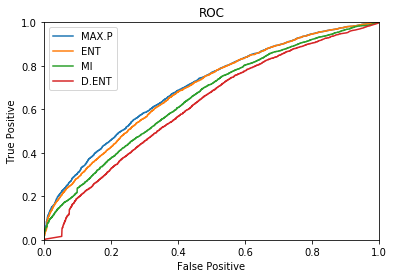

In [0]:
from miscood import plot_roc, plot_pr, get_test_roc_pr

auroc_mp, aupr_mp, label_mp, score_mp = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, label_ent, score_ent = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, label_mi, score_mi = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, label_de, score_de = get_test_roc_pr(dpn, 'DE', 'misc')

plot_roc(label_mp, score_mp, label_name='MAX.P')
plot_roc(label_ent, score_ent, label_name='ENT')
plot_roc(label_mi, score_mi, label_name='MI')
plot_roc(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

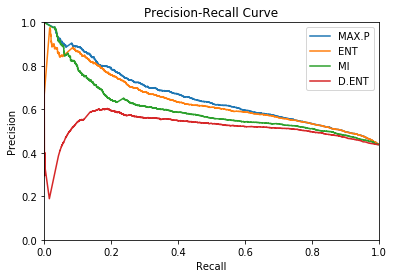

In [0]:
plot_pr(label_mp, score_mp, label_name='MAX.P')
plot_pr(label_ent, score_ent, label_name='ENT')
plot_pr(label_mi, score_mi, label_name='MI')
plot_pr(label_de, score_de, label_name='D.ENT')
plt.legend()
plt.show()

The area under curves summarize the skill of a model across thresholds, hence they are perfect metrics for evaluating uncertainty prediction performance. 

#### Results

In [0]:
import pandas as pd

auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dpn, 'MAXP', 'misc')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dpn, 'ENT', 'misc')
auroc_mi, aupr_mi, _, _ = get_test_roc_pr(dpn, 'MI', 'misc')
auroc_de, aupr_de, _, _ = get_test_roc_pr(dpn, 'DE', 'misc')

auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.702663,0.693451,0.652438,0.617857
AUPR,0.658318,0.638262,0.599560,0.514709


Our results align with the results obtained by Malinin and Gales in their DPN paper. 
For misclassification task, max probability yields the best results, closely followed by the entropy of the predictive distribution. This is expected, as they are measures of *total uncertainty* in predictions, while the other measures capture the either model or distributional uncertainty.

Similar to the paper, for evaluating the performance of uncertainty estimation compared with traditional models, we trained a DNN on MNIST, and test its performance in detecting misclassification. Note that DNN cannot use MI and differential entropy as uncertainty measure, since in DNN model, $\mu$ is marginalized out, as discussed in previous sections. 

In [0]:
from dpn import DNN

dnn = DNN()
if torch.cuda.is_available(): dnn.cuda()
optimizer = optim.Adam(dnn.parameters(), lr=0.001)

dnn.test()
dnn.fit(optimizer, 30)
dnn.test()

auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'misc')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'misc')

auroc_lst = [auroc_mp, auroc_ent]
aupr_lst = [aupr_mp, aupr_ent]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent
AUROC,0.581222,0.835369
AUPR,0.327439,0.399853


As we can see, the DPN generally outperforms DNN in detecting misclassification, although DNN has better AUROC statistic when using entropy.  

### OOD Detection Experiment

We now try to reproduce OOD detection task. 
We treat the OOD examples as the positive class and in-domain examples as a negative class. Since we enforce the DPN to produce *flat Dirichlet* distributions over the simplex for OOD examples during the training of DPN, the differential entropy measure should produce higher scores for OOD examples and lower scores for in-domain examples, even if they have strong data uncertainty (the overlapped area), as we observed in the synthetic experiment.

In this experiment, we continue using Fashion-MNIST as the OOD data for in-domain MNIST dataset. 

In [0]:
auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dpn, 'MAXP', 'ood')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dpn, 'ENT', 'ood')
auroc_mi, aupr_mi, _, _ = get_test_roc_pr(dpn, 'MI', 'ood')
auroc_de, aupr_de, _, _ = get_test_roc_pr(dpn, 'DE', 'ood')

auroc_lst = [auroc_mp, auroc_ent, auroc_mi, auroc_de]
aupr_lst = [aupr_mp, aupr_ent, aupr_mi, aupr_de]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent', 'MI', 'D.Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent,MI,D.Ent
AUROC,0.765579,0.769737,0.801438,0.732534
AUPR,0.746836,0.745356,0.780649,0.635239


Similar to the results from the paper, we didn't observe a significant superior of detecting OOD examples by using differential entropy. One explanation from the paper is that since MNIST dataset is *low data uncertainty datasets*. All of the classes in MNIST are distinct from each other and there are little data uncertainty in this dataset, i.e. there are no data overlapping area as we have in the synthetic experiment. 

**Another explanation origins from the experience of our own experiments**. We found that when we set the $\alpha$ for the label of in-domain dataset too large, say 1000, the training of DPN will be very unstable and can hardly converge. Hence we need to use smaller $\alpha$ like 10 or 50. This constraints the differences of differential entropy between overlapped data and OOD data, hence the OOD data are not easy to be distinguished by DPN. We think **stablizing the training of DPN** can be a future work. 

As the misclassification detection test, we also did OOD detection by using DNN for comparison. 

In [0]:
auroc_mp, aupr_mp, _, _ = get_test_roc_pr(dnn, 'MAXP', 'ood')
auroc_ent, aupr_ent, _, _ = get_test_roc_pr(dnn, 'ENT', 'ood')

auroc_lst = [auroc_mp, auroc_ent]
aupr_lst = [aupr_mp, aupr_ent]

pd.DataFrame(data=np.array([auroc_lst, aupr_lst]), 
             columns=['Max.P', 'Ent'], 
             index=['AUROC', 'AUPR'])

,Max.P,Ent
AUROC,0.629186,0.873437
AUPR,0.796798,0.907974


To our surprise, in our experiment, DNN actually has better performance in detecting OOD data. We suspect that since MNIST is an easy dataset, DNN can get accuracy to 97% with only one epoch of training, there are very little data uncertainty in MNIST data. Hence DNN can have OOD detecting accuracy just as good as DPN. Besides, for DPN, the training is hard and unstable with KL loss, the performance is usually not as good as the paper suggests. Hence, improving the loss function and training method for DPN will be a valuable future research direction. 

## Follow-up Studies

During our experiments, we found that training Prior Networks on complex datasets with more classes (e.g. MNIST has 10 classes) is difficult using the training criteria proposed in the paper. After some researches, we found that a Reverse KL-loss for DPN is proposed in [2], where a better OOD detection performance is obtained. We also found another paper [3] in ICLR2020, which presents an improved DPN framework using the standard cross-entropy loss along with a regularization term. Prior network is a significant contribution to uncertainty estimation tools, and we believe that improving its training method will continue to be a hot research topic in the future. 

# Sources

[1] Formal Security Analysis of Neural Networks using Symbolic Intervals https://arxiv.org/abs/1804.10829 (2018)

[2] Reverse KL-Divergence Training of Prior Networks: Improved Uncertainty and Adversarial Robustness
https://arxiv.org/pdf/1905.13472.pdf (2019)

[3] Improving Dirichlet Prior Network for Out-of-Distribution Example Detection
https://openreview.net/pdf?id=Bye4iaEFwr (2019)

[4] Yann LeCun and Corinna Cortes. 2010. MNIST handwritten digit database. http://yann.lecun.com/exdb/mnist/. (2010).

[5] Fashion-MNIST: a Novel Image Dataset for Benchmarking Machine Learning Algorithms. Han Xiao, Kashif Rasul, Roland Vollgraf.

[6] Simple and Scalable Predictive Uncertainty
Estimation using Deep Ensembles. https://arxiv.org/pdf/1612.01474.pdf (2016)

[7] Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning. https://arxiv.org/pdf/1506.02142.pdf (2015)

[8] Training confidence-calibrated
classifiers for detecting out-of-distribution samples. https://arxiv.org/pdf/1711.09325.pdf (2017)

[9] Incorporating Uncertainty into Deep Learning for Spoken Language Assessment. http://mi.eng.cam.ac.uk/~am969/incorporating.pdf 

[10] Dan Hendrycks and Kevin Gimpel, “A Baseline for Detecting Misclassified and Out-of- Distribution Examples in Neural Networks,” http://arxiv.org/abs/1610.02136, (2016)
